In [1]:

# Required imports
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from torchvision.models.mobilenetv2 import InvertedResidual
from torchvision.models import MobileNet_V2_Weights
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg')  # non-GUI backend

# Import SAM
sys.path.append('../models')
from sam import SAM

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
weights = MobileNet_V2_Weights.DEFAULT
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    weights.transforms()
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

# Load dataset
full_train_dataset = datasets.ImageFolder('../../dataset_split/train', transform=train_transforms)
full_val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=val_transforms)

# Select classes
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

class ReindexedSubset(Dataset):
    def __init__(self, subset, class_indices_mapping):
        self.subset = subset
        self.mapping = class_indices_mapping

    def __getitem__(self, index):
        x, y = self.subset[index]
        y = self.mapping[y]
        return x, y

    def __len__(self):
        return len(self.subset)

def filter_and_remap(dataset, class_indices, mapping):
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_indices]
    subset = Subset(dataset, indices)
    return ReindexedSubset(subset, mapping)

train_dataset = filter_and_remap(full_train_dataset, selected_class_indices, index_mapping)
val_dataset = filter_and_remap(full_val_dataset, selected_class_indices, index_mapping)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define model
class MobileNetV2_SAM(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MobileNetV2_SAM, self).__init__()
        self.features = nn.Sequential()
        for name, module in base_model.features._modules.items():
            self.features.add_module(name, module)
            if isinstance(module, InvertedResidual):
                conv_layers = [layer for layer in module.conv if isinstance(layer, nn.Conv2d)]
                out_channels = conv_layers[-1].out_channels if conv_layers else base_model.last_channel
                self.features.add_module(f"sam_{name}", SAM(out_channels))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

base_model = models.mobilenet_v2(weights=weights)
model = MobileNetV2_SAM(base_model, len(selected_classes)).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Train
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()
    acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

# Save model
torch.save(model.state_dict(), "mobilenet_v2_sam.pth")

# Evaluate
model.eval()
all_labels, all_preds, all_features = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        features = model.features(images).mean(dim=[2, 3])  # global avg pool features
        _, predicted = torch.max(outputs, 1)
        all_features.append(features.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Reports
print(classification_report(all_labels, all_preds, target_names=selected_classes))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confMatrix_sam.png")

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Single image prediction example
images, labels = next(iter(val_loader))
input_tensor = images[0].unsqueeze(0).to(device)
true_label = labels[0].item()

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    pred_label = predicted.item()

image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.title(f"True: {selected_classes[true_label]} | Predicted: {selected_classes[pred_label]}")
plt.axis('off')
plt.savefig("test_output_sam.png")

# Grad-CAM (simplified version)
def apply_gradcam(model, input_tensor):
    model.eval()
    gradients = []

    def save_gradient(grad):
        gradients.append(grad)

    # Choose last SAM layer
    for name, module in reversed(list(model.features.named_children())):
        if 'sam' in name:
            target_layer = module
            break

    def forward_hook(module, input, output):
        output.register_hook(save_gradient)
        return output

    handle = target_layer.register_forward_hook(forward_hook)
    output = model(input_tensor)
    pred_class = output.argmax().item()
    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()
    handle.remove()

    gradient = gradients[0][0].cpu().numpy()
    activation = target_layer(input_tensor).detach()[0].cpu().numpy()
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * activation, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = plt.cm.jet(cam)[..., :3]

    orig_image = input_tensor[0].cpu().permute(1, 2, 0).numpy()
    orig_image = orig_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    orig_image = np.clip(orig_image, 0, 1)
    overlay = 0.5 * cam + 0.5 * orig_image
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM SAM")
    plt.savefig("gradcam_sam_layer.png")

apply_gradcam(model, input_tensor)

# t-SNE Visualization
all_features = torch.cat(all_features, dim=0).numpy()
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(8,6))
for i, label in enumerate(np.unique(all_labels)):
    indices = np.where(np.array(all_labels) == label)
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=selected_classes[label], alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization SAM")
plt.savefig("tsne_plot_sam.png")



Epoch 1/100: 100%|██████████| 91/91 [01:56<00:00,  1.28s/it]


Epoch [1/100], Loss: 45.8430, Accuracy: 0.7301


Epoch 2/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [2/100], Loss: 34.4989, Accuracy: 0.8245


Epoch 3/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [3/100], Loss: 27.5596, Accuracy: 0.8658


Epoch 4/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [4/100], Loss: 23.8451, Accuracy: 0.8894


Epoch 5/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [5/100], Loss: 22.6441, Accuracy: 0.8900


Epoch 6/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [6/100], Loss: 21.6018, Accuracy: 0.8970


Epoch 7/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [7/100], Loss: 21.8081, Accuracy: 0.8949


Epoch 8/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [8/100], Loss: 21.8746, Accuracy: 0.9005


Epoch 9/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [9/100], Loss: 20.3152, Accuracy: 0.8994


Epoch 10/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [10/100], Loss: 21.8049, Accuracy: 0.9039


Epoch 11/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [11/100], Loss: 21.4542, Accuracy: 0.9018


Epoch 12/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [12/100], Loss: 21.2767, Accuracy: 0.9001


Epoch 13/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [13/100], Loss: 20.7502, Accuracy: 0.9005


Epoch 14/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [14/100], Loss: 21.9367, Accuracy: 0.8959


Epoch 15/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [15/100], Loss: 22.5051, Accuracy: 0.8939


Epoch 16/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [16/100], Loss: 21.0225, Accuracy: 0.9005


Epoch 17/100: 100%|██████████| 91/91 [01:53<00:00,  1.25s/it]


Epoch [17/100], Loss: 20.9535, Accuracy: 0.9043


Epoch 18/100: 100%|██████████| 91/91 [02:01<00:00,  1.33s/it]


Epoch [18/100], Loss: 21.2372, Accuracy: 0.9008


Epoch 19/100: 100%|██████████| 91/91 [02:00<00:00,  1.33s/it]


Epoch [19/100], Loss: 22.0122, Accuracy: 0.9015


Epoch 20/100: 100%|██████████| 91/91 [01:59<00:00,  1.31s/it]


Epoch [20/100], Loss: 22.0541, Accuracy: 0.9032


Epoch 21/100: 100%|██████████| 91/91 [01:55<00:00,  1.27s/it]


Epoch [21/100], Loss: 20.5592, Accuracy: 0.9060


Epoch 22/100: 100%|██████████| 91/91 [02:01<00:00,  1.34s/it]


Epoch [22/100], Loss: 21.5472, Accuracy: 0.9008


Epoch 23/100: 100%|██████████| 91/91 [02:07<00:00,  1.40s/it]


Epoch [23/100], Loss: 21.4640, Accuracy: 0.8987


Epoch 24/100: 100%|██████████| 91/91 [02:07<00:00,  1.40s/it]


Epoch [24/100], Loss: 22.1308, Accuracy: 0.8994


Epoch 25/100: 100%|██████████| 91/91 [01:54<00:00,  1.26s/it]


Epoch [25/100], Loss: 20.6148, Accuracy: 0.9084


Epoch 26/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [26/100], Loss: 20.3878, Accuracy: 0.9015


Epoch 27/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [27/100], Loss: 22.0997, Accuracy: 0.8918


Epoch 28/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [28/100], Loss: 20.7523, Accuracy: 0.9060


Epoch 29/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [29/100], Loss: 22.0829, Accuracy: 0.8904


Epoch 30/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [30/100], Loss: 20.7531, Accuracy: 0.9005


Epoch 31/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [31/100], Loss: 21.5018, Accuracy: 0.9053


Epoch 32/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [32/100], Loss: 22.0587, Accuracy: 0.9043


Epoch 33/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [33/100], Loss: 20.4491, Accuracy: 0.9084


Epoch 34/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [34/100], Loss: 21.0183, Accuracy: 0.9070


Epoch 35/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [35/100], Loss: 21.2391, Accuracy: 0.9022


Epoch 36/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [36/100], Loss: 21.1187, Accuracy: 0.8998


Epoch 37/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [37/100], Loss: 21.1507, Accuracy: 0.9032


Epoch 38/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [38/100], Loss: 23.3534, Accuracy: 0.8921


Epoch 39/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [39/100], Loss: 21.9171, Accuracy: 0.8956


Epoch 40/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [40/100], Loss: 21.4874, Accuracy: 0.8994


Epoch 41/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [41/100], Loss: 23.8974, Accuracy: 0.8966


Epoch 42/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [42/100], Loss: 20.5580, Accuracy: 0.8994


Epoch 43/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [43/100], Loss: 21.2528, Accuracy: 0.9018


Epoch 44/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [44/100], Loss: 20.8531, Accuracy: 0.9011


Epoch 45/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [45/100], Loss: 22.3186, Accuracy: 0.8932


Epoch 46/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [46/100], Loss: 20.8388, Accuracy: 0.9018


Epoch 47/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [47/100], Loss: 20.2506, Accuracy: 0.9060


Epoch 48/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [48/100], Loss: 21.1555, Accuracy: 0.8959


Epoch 49/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [49/100], Loss: 21.4516, Accuracy: 0.8952


Epoch 50/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [50/100], Loss: 21.6243, Accuracy: 0.8963


Epoch 51/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [51/100], Loss: 20.9927, Accuracy: 0.9008


Epoch 52/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [52/100], Loss: 20.8982, Accuracy: 0.9011


Epoch 53/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [53/100], Loss: 21.4537, Accuracy: 0.9011


Epoch 54/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [54/100], Loss: 20.9828, Accuracy: 0.8970


Epoch 55/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [55/100], Loss: 21.3263, Accuracy: 0.8963


Epoch 56/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [56/100], Loss: 21.8217, Accuracy: 0.8984


Epoch 57/100: 100%|██████████| 91/91 [01:51<00:00,  1.22s/it]


Epoch [57/100], Loss: 21.3142, Accuracy: 0.9032


Epoch 58/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [58/100], Loss: 20.5751, Accuracy: 0.9046


Epoch 59/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [59/100], Loss: 22.1163, Accuracy: 0.8977


Epoch 60/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [60/100], Loss: 21.2963, Accuracy: 0.9074


Epoch 61/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [61/100], Loss: 22.3939, Accuracy: 0.8925


Epoch 62/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [62/100], Loss: 21.7302, Accuracy: 0.8991


Epoch 63/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [63/100], Loss: 23.4222, Accuracy: 0.9032


Epoch 64/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [64/100], Loss: 21.1937, Accuracy: 0.9050


Epoch 65/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [65/100], Loss: 21.1032, Accuracy: 0.9043


Epoch 66/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [66/100], Loss: 21.2994, Accuracy: 0.8991


Epoch 67/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [67/100], Loss: 22.8553, Accuracy: 0.9008


Epoch 68/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [68/100], Loss: 20.9593, Accuracy: 0.9011


Epoch 69/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [69/100], Loss: 21.2981, Accuracy: 0.9018


Epoch 70/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [70/100], Loss: 21.2081, Accuracy: 0.9043


Epoch 71/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [71/100], Loss: 21.1820, Accuracy: 0.9011


Epoch 72/100: 100%|██████████| 91/91 [01:53<00:00,  1.25s/it]


Epoch [72/100], Loss: 21.1428, Accuracy: 0.9025


Epoch 73/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [73/100], Loss: 21.7758, Accuracy: 0.8946


Epoch 74/100: 100%|██████████| 91/91 [01:54<00:00,  1.25s/it]


Epoch [74/100], Loss: 22.9876, Accuracy: 0.8994


Epoch 75/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [75/100], Loss: 21.3104, Accuracy: 0.8980


Epoch 76/100: 100%|██████████| 91/91 [01:54<00:00,  1.26s/it]


Epoch [76/100], Loss: 22.4778, Accuracy: 0.9015


Epoch 77/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [77/100], Loss: 21.5855, Accuracy: 0.8959


Epoch 78/100: 100%|██████████| 91/91 [01:53<00:00,  1.25s/it]


Epoch [78/100], Loss: 21.0680, Accuracy: 0.8994


Epoch 79/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [79/100], Loss: 21.2827, Accuracy: 0.8998


Epoch 80/100: 100%|██████████| 91/91 [01:53<00:00,  1.25s/it]


Epoch [80/100], Loss: 21.3279, Accuracy: 0.9036


Epoch 81/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [81/100], Loss: 21.4176, Accuracy: 0.8966


Epoch 82/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [82/100], Loss: 21.3890, Accuracy: 0.8987


Epoch 83/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [83/100], Loss: 21.2981, Accuracy: 0.9029


Epoch 84/100: 100%|██████████| 91/91 [01:53<00:00,  1.25s/it]


Epoch [84/100], Loss: 20.2224, Accuracy: 0.9088


Epoch 85/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [85/100], Loss: 20.6803, Accuracy: 0.9070


Epoch 86/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [86/100], Loss: 20.8069, Accuracy: 0.8984


Epoch 87/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [87/100], Loss: 21.9611, Accuracy: 0.9060


Epoch 88/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [88/100], Loss: 20.9162, Accuracy: 0.9015


Epoch 89/100: 100%|██████████| 91/91 [01:53<00:00,  1.24s/it]


Epoch [89/100], Loss: 21.8498, Accuracy: 0.8998


Epoch 90/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [90/100], Loss: 20.9996, Accuracy: 0.9005


Epoch 91/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [91/100], Loss: 21.3899, Accuracy: 0.8970


Epoch 92/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [92/100], Loss: 23.6525, Accuracy: 0.9018


Epoch 93/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [93/100], Loss: 21.5918, Accuracy: 0.9018


Epoch 94/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [94/100], Loss: 20.2931, Accuracy: 0.9070


Epoch 95/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [95/100], Loss: 21.6475, Accuracy: 0.8932


Epoch 96/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [96/100], Loss: 21.7706, Accuracy: 0.8966


Epoch 97/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [97/100], Loss: 20.9865, Accuracy: 0.9074


Epoch 98/100: 100%|██████████| 91/91 [01:51<00:00,  1.23s/it]


Epoch [98/100], Loss: 21.5031, Accuracy: 0.9036


Epoch 99/100: 100%|██████████| 91/91 [01:52<00:00,  1.23s/it]


Epoch [99/100], Loss: 21.7376, Accuracy: 0.9018


Epoch 100/100: 100%|██████████| 91/91 [01:52<00:00,  1.24s/it]


Epoch [100/100], Loss: 21.2370, Accuracy: 0.8977
                       precision    recall  f1-score   support

 Tomato___Late_blight       0.96      0.91      0.94       940
Potato___Early_blight       0.85      0.93      0.89       494

             accuracy                           0.92      1434
            macro avg       0.90      0.92      0.91      1434
         weighted avg       0.92      0.92      0.92      1434

F1 Score: 0.9185 | Precision: 0.9215 | Recall: 0.9177


ValueError: operands could not be broadcast together with shapes (320,1,1) (3,224,224) 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

def apply_gradcam(model, input_tensor, target_layer_name="sam_17"):
    activations = []
    gradients = []

    try:
        # اختيار الطبقة المستهدفة
        target_layer = model.features._modules[target_layer_name]
    except KeyError:
        print(f"[ERROR] Layer '{target_layer_name}' not found in model.features.")
        print("Available layers:")
        for name in model.features._modules.keys():
            print("-", name)
        return

    # Hooks
    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward and backward
    model.eval()
    output = model(input_tensor)
    class_idx = output.argmax().item()
    print("[INFO] Predicted class index:", class_idx)
    loss = output[0, class_idx]
    loss.backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    if not activations or not gradients:
        print("[ERROR] Activations or gradients are empty.")
        return

    act = activations[0].detach().cpu().squeeze(0).numpy()  # (C, H, W)
    grad = gradients[0].detach().cpu().squeeze(0).numpy()   # (C, H, W)

    print("Activation shape:", act.shape)
    print("Gradient shape:", grad.shape)

    # Compute weights and CAM
    weights = np.mean(grad, axis=(1, 2))                    # (C,)
    cam = np.sum(weights[:, None, None] * act, axis=0)

    if np.isnan(cam).any() or np.max(cam) == 0:
        print("[ERROR] CAM contains NaNs or all values are zero.")
        return

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224, 224))

    # Visualization
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title(f"Grad-CAM {target_layer_name}")
    save_path = f"gradcam_{target_layer_name}.png"
    plt.savefig(save_path)
    plt.show()

    print(f"[SUCCESS] Saved Grad-CAM to {save_path}")


/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[INFO] Predicted class index: 1
Activation shape: (320, 7, 7)
Gradient shape: (320, 7, 7)


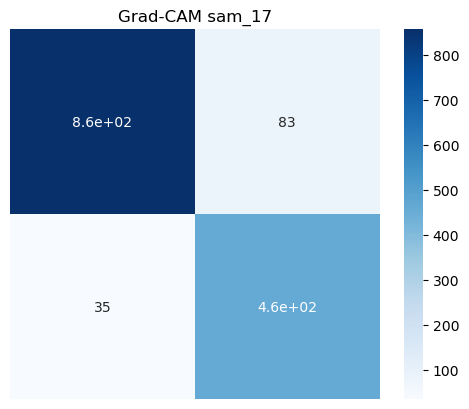

[SUCCESS] Saved Grad-CAM to gradcam_sam_17.png


In [15]:
apply_gradcam(model, input_tensor, target_layer_name="sam_17")


In [14]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
num_classes = len(selected_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = models.mobilenet_v2(weights="DEFAULT")
model = MobileNetV2_SAM(base_model, num_classes=num_classes).to(device)

def extract_features_tsne(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            pooled = nn.AdaptiveAvgPool2d((1, 1))(outputs)
            pooled = pooled.view(pooled.size(0), -1)
            features.append(pooled.cpu())
            labels.append(targets)
    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return features, labels

def plot_tsne(features, labels, class_names):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
    tsne_results = tsne.fit_transform(features)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
                    hue=[class_names[label] for label in labels],
                    palette="deep", s=60, alpha=0.7)
    plt.title("t-SNE Visualization of SAM Features")
    plt.legend()
    plt.tight_layout()
    plt.savefig("tsne_sam.png")
    plt.show()

features, labels = extract_features_tsne(model, test_loader, device)
plot_tsne(features, labels, selected_classes)


NameError: name 'MobileNetV2_SAM' is not defined